# **TCGA Hyperparameter search**



# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import scipy
import anndata as ad


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from sklearn.model_selection import train_test_split


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2024-06-12 11:18:41.301803: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 11:18:41.302976: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 11:18:41.324667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 11:18:41.325420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:18:41.681081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/pseudobulks/"
res_data_path = f"{os.getcwd()}/../results/buddiM2_tcga/"

cfdna_file = f"{os.getcwd()}/../data/cfDNA/cfdna_processed_all.h5ad"

regions_path = f"{os.getcwd()}/../data/reference/TCGA_regions.csv"


num_genes = 7000

exp_id = "all-tcga"
res_id = "all-tcga"

RETRAIN_MODELS = False


# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 13

# number of patients/domains/samples expected
n_tot_samples = 531 # all TCGA samples 525 + cfdna 6

# number of drugs 
# one-hot encoded
n_drugs = 8

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
# read cfDNA in
cfdna_adata = ad.read_h5ad(cfdna_file)
cfdna_adata = cfdna_adata[cfdna_adata.obs.cancer_type != "LIHC"]

cfdna_test = cfdna_adata[[0,1,8]]
cfdna_adata = cfdna_adata[2:8]

sc.pp.normalize_total(cfdna_adata, target_sum=1e7) 


# format counts into dataframe
cfdna_X = pd.DataFrame(cfdna_adata.X.todense())
cfdna_X.columns = cfdna_adata.var.gene_ids

# make metadata table
meta_cfdna = cfdna_adata.obs
meta_cfdna = meta_cfdna[["sample_id", "cancer_type"]]
meta_cfdna["isTraining"] = "Train"
meta_cfdna["num_blood"] = 0
meta_cfdna["samp_type"] = "bulk"


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
cfdna_X

gene_ids  chr1:17238-17739  chr1:817118-817619  chr1:826524-827025  \
0                15.049328           86.888573           74.678741   
1                25.361139           60.119488          138.014420   
2                22.255302           45.527988           79.483223   
3                46.447590           55.396210          120.309204   
4                 3.543494           56.051624           72.641617   
5                15.832536           57.879597           88.766022   

gene_ids  chr1:827303-827804  chr1:830679-831180  chr1:877099-877600  \
0                  48.129456           69.709625          147.227859   
1                 109.256699           94.538177          133.032761   
2                  63.713753           76.303894          180.967407   
3                  97.440514          119.741035          126.416992   
4                  50.736385           96.962868          151.564880   
5                  79.032906           80.849754           45.031883   

gene_ids  chr1:920320-920821  chr1:925423-925924  chr1:929911-930412  \
0                 161.851257           93.703362          180.166016   
1                 141.750656          156.242737          147.864502   
2                 228.911682          105.426544          199.407501   
3                 181.955246          110.366295          242.322906   
4                 249.010956          154.625168          158.329727   
5                 218.021805           92.399719          152.485489   

gene_ids  chr1:938609-939110  ...  chrX:155264243-155264744  \
0                 187.832657  ...                221.480682   
1                 188.283813  ...                353.244446   
2                 218.737823  ...                167.868561   
3                 159.370636  ...                285.077423   
4                 161.067886  ...                220.663010   
5                 164.684326  ...                155.729858   

gene_ids  chrX:155334487-155334988  chrX:155334996-155335497  \
0                       255.554626                273.869385   
1                       325.279266                295.502563   
2                       352.269653                328.106750   
3                       296.724823                269.594879   
4                       234.836975                255.292603   
5                       171.302841                186.875839   

gene_ids  chrX:155612717-155613218  chrX:155766937-155767438  \
0                       187.122772                187.406723   
1                       153.299026                321.543030   
2                       270.115784                346.038147   
3                       292.889709                234.368576   
4                       184.583801                305.062592   
5                       117.316498                256.954254   

gene_ids  chrX:155767443-155767944  chrX:155880523-155881024  \
0                       176.048737                226.875717   
1                       296.747986                219.645584   
2                       272.277740                207.165070   
3                       198.716141                294.878296   
4                       260.929993                231.132416   
5                       252.671692                305.100739   

gene_ids  chrX:155881036-155881537  chrX:156003787-156004288  \
0                       221.196732                231.418915   
1                       183.415390                257.913727   
2                       175.626129                157.313187   
3                       270.873260                151.984467   
4                       210.354660                205.200485   
5                       258.381805                197.647141   

gene_ids  chrX:156005167-156005668  
0                       212.252319  
1                       217.154755  
2                       202.078140  
3                       163.773926  
4                       238.541550  
5                       247.221146  

[

In [6]:
meta_cfdna

sample_id cancer_type isTraining  num_blood samp_type
BRCA_IC46 -1-0-0-0-0-0  BRCA_IC46         BRCA      Train          0      bulk
BRCA_IC34 -1-0-0-0-0    BRCA_IC34         BRCA      Train          0      bulk
BRCA_IC12 -1-0-0-0      BRCA_IC12         BRCA      Train          0      bulk
BRCA_IC04 -1-0-0        BRCA_IC04         BRCA      Train          0      bulk
LUNG_IC42 -1-0          LUNG_IC42         LUNG      Train          0      bulk
LUNG_IC06 -0-1          LUNG_IC06         LUNG      Train          0      bulk

In [7]:
cfdna_test

View of AnnData object with n_obs × n_vars = 3 × 45782
    obs: 'sample_id', 'cancer_type', 'batch'
    var: 'Chromosome', 'Start', 'End', 'gene_ids'

In [8]:


# now get the training data

# read in order
# oritinal samples
sample_order = [5001, 5000, 1000, 500, 100, 19000, 99000, 99900]

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_train = X_concat
Y_train = Y_concat
meta_train = meta_concat
meta_train.cancer_type = meta_train.cancer_type.astype('str')
meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"
meta_train["samp_type"] = "sc"




X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_test = X_concat
Y_test = Y_concat
meta_test = meta_concat
meta_test.cancer_type = meta_test.cancer_type.astype('str')
meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"
meta_test["samp_type"] = "sc"
meta_test.isTraining = "Train"

cancer_df = pd.get_dummies(meta_train.cancer_type.tolist() + 
                            meta_test.cancer_type.tolist() + 
                            meta_cfdna.cancer_type.tolist())


X_full = pd.concat([X_train, X_test, cfdna_X])

# make a temp Y for the unlabeled ones
Y_cfdna = Y_test.iloc[np.random.choice(range(Y_test.shape[0]), cfdna_X.shape[0])]
Y_full = pd.concat([Y_train, Y_test, Y_cfdna])
meta_df = pd.concat([meta_train, meta_test, meta_cfdna])




5001
5000
1000


500
100
19000
99000
99900
5001
5000


/tmp/ipykernel_944811/3232828442.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"


1000
500
100
19000
99000
99900


/tmp/ipykernel_944811/3232828442.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"


In [9]:
cancer_df

BRCA  COAD  KIDNEY  LIHC  LUNG  PRAD  STAD  blood
0        0     0       0     0     0     0     0      1
1        0     0       0     0     0     0     0      1
2        0     0       0     0     0     0     0      1
3        0     0       0     0     0     0     0      1
4        0     0       0     0     0     0     0      1
...    ...   ...     ...   ...   ...   ...   ...    ...
4201     1     0       0     0     0     0     0      0
4202     1     0       0     0     0     0     0      0
4203     1     0       0     0     0     0     0      0
4204     0     0       0     0     1     0     0      0
4205     0     0       0     0     1     0     0      0

[4206 rows x 8 columns]

In [10]:
X_train

gene_ids  chr1:17238-17739  chr1:817118-817619  chr1:826524-827025  \
0                 3.669233          167.498291           74.488679   
0                14.527142          490.860690           98.278484   
0                 0.000000           79.033224           73.005080   
0                 6.040070          275.288099          120.662549   
0                 8.411984          284.353116           83.084651   
..                     ...                 ...                 ...   
0                61.775983         7164.206651         2331.417138   
0                46.000197         7191.750587         3044.722696   
0                33.183970         1372.704805         1845.050328   
0                58.320592         4396.659919         2244.350059   
0               157.054936         3162.727985         2083.831676   

gene_ids  chr1:827303-827804  chr1:830679-831180  chr1:877099-877600  \
0                1644.707984           78.992966           35.097146   
0                1541.248113           20.035165           79.575459   
0                1275.038236           35.827169           57.536242   
0                1220.277084           53.739607           79.171080   
0                1445.422539           22.088875           52.448375   
..                       ...                 ...                 ...   
0               31905.322372          896.564900         1208.706100   
0               33624.922531         1068.538999         1048.285538   
0               34257.720873          369.645540          877.329661   
0               33610.930288          917.134012         1046.296664   
0               34106.785777          864.050950         1070.418827   

gene_ids  chr1:920320-920821  chr1:925423-925924  chr1:929911-930412  \
0                  70.407839          788.321251           47.722462   
0                 101.632544          616.319721           76.702873   
0                  83.565576          643.849052           86.035861   
0                 136.804386          605.123919           65.974759   
0                 164.640627          566.856123           74.406325   
..                       ...                 ...                 ...   
0                2324.021420        11384.989677         2054.181701   
0                2652.101470        10913.761427         1722.949691   
0                1594.414651        10640.243198         1194.239083   
0                1997.884498        10295.727726          978.675756   
0                2297.351940        10307.887423         1158.436327   

gene_ids  chr1:938609-939110  ...  chrX:155264243-155264744  \
0                 159.393929  ...                647.027838   
0                 201.593548  ...                592.554985   
0                 144.900578  ...                593.280917   
0                 184.387994  ...                457.813238   
0                 162.565101  ...                578.544547   
..                       ...  ...                       ...   
0                3359.891469  ...              10025.056274   
0                3501.646338  ...              10975.429098   
0                2489.182080  ...              14302.462031   
0                1955.260560  ...              11391.018706   
0                2171.951504  ...              10993.748744   

gene_ids  chrX:155334487-155334988  chrX:155334996-155335497  \
0                        16.694780                 20.340139   
0                        45.156926                103.735053   
0                        51.608102                 71.294047   
0                       460.226777                526.644866   
0                        34.266081                 70.640006   
..                             ...                       ...   
0                      3375.004604               4097.621408   
0                      2750.653427               4233.915696   
0                       258.203698               1107.838121   
0                       757.0631

In [11]:
# double check all the pseudobulks/bulks were read in
meta_df.samp_type.value_counts()

sc      4200
bulk       6
Name: samp_type, dtype: int64

In [12]:


# how many of each cancer type
tab = meta_df.groupby(['cancer_type', 'samp_type']).size()
tab.unstack()

samp_type    bulk     sc
cancer_type             
BRCA          4.0  987.0
COAD          NaN  567.0
KIDNEY        NaN  700.0
LIHC          NaN  238.0
LUNG          2.0  532.0
PRAD          NaN  364.0
STAD          NaN  287.0
blood         NaN  525.0

In [13]:
# how many of each technology
tab = meta_df.groupby(['samp_type', 'isTraining']).size()
tab.unstack()

isTraining  Train
samp_type        
bulk            6
sc           4200

In [14]:
# check correlation of pseudobulks
bulk_check0 = 5

print(np.corrcoef((X_train.iloc[bulk_check0] / np.sum(X_train.iloc[bulk_check0])), (cfdna_X.iloc[bulk_check0] / np.sum(cfdna_X.iloc[bulk_check0]))))


[[ 1.         -0.35140629]
 [-0.35140629  1.        ]]


# Define indices and set-up metadata

In [15]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)

samp_drug = np.asarray(meta_df.cancer_type)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining=="Test")[0] 
idx_heldout = np.where(meta_df.isTraining=="heldout")[0] 
idx_bulk = np.where(meta_df.samp_type=="bulk")[0] 
idx_sc = np.where(meta_df.samp_type=="sc")[0] 

Y_max = np.copy(cancer_df)
Y_max = np.argmax(Y_max, axis=1)
Y_max = cancer_df.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the regions genes
regions_df = pd.read_csv(regions_path, sep="," )
regions_genes = regions_df["seqnames"].astype(str) + ":" + regions_df["start"].astype(str) + "-" + regions_df["end"].astype(str)

# only keep regions genes that are in common genes
regions_genes = np.intersect1d(gene_df, regions_genes)

# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# regionsx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, regions_genes)
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 1550
gene_df = gene_df.iloc[idx_top]


In [16]:
regions_df.cancer.value_counts()

KIDNEY    583
LIHC      487
BRCA      485
PRAD      427
LUNG      270
COAD      239
STAD       30
Name: cancer, dtype: int64

In [17]:
X_CoV.shape

(45782,)

# compare our variable genes with cibersort defined genes

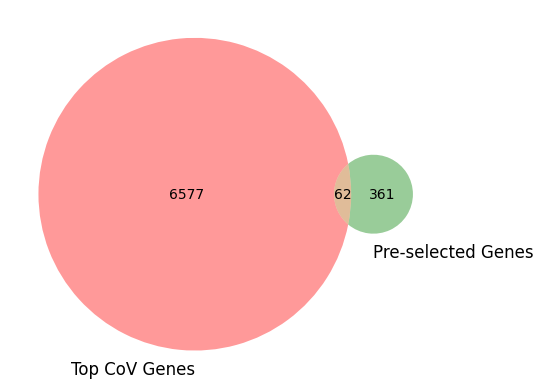

In [18]:

venn2([set(gene_df), set(regions_genes)], set_labels = ('Top CoV Genes', 'Pre-selected Genes'))
plt.show()

In [19]:
union_genes = np.union1d(gene_df, regions_genes)

len(union_genes)

7000

# Normalize data

In [20]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
X_unkp = X_full[idx_bulk,]
label_unkp = label_full[idx_bulk,]
bulk_unkp = bulk_full[idx_bulk,]
drug_unkp = drug_full[idx_bulk,]
y_unkp = Y_full.iloc[idx_bulk]
y_unkp = y_unkp.to_numpy()

# for known proportions
X_kp = X_full[idx_sc,]
label_kp = label_full[idx_sc,]
bulk_kp = bulk_full[idx_sc,]
drug_kp = drug_full[idx_sc,]
y_kp = Y_full.iloc[idx_sc]
y_kp = y_kp.to_numpy()


In [21]:
idx_sc

array([   0,    1,    2, ..., 4197, 4198, 4199])

In [22]:
y_kp

array([[0.21195761, 0.16016797, 0.01019796, ..., 0.18836233, 0.01419716,
        0.01019796],
       [0.10317936, 0.01059788, 0.064987  , ..., 0.14157169, 0.00419916,
        0.0309938 ],
       [0.00319936, 0.02439512, 0.67646471, ..., 0.13157369, 0.02559488,
        0.02939412],
       ...,
       [0.41671672, 0.02722723, 0.09802803, ..., 0.02965966, 0.11342342,
        0.00328328],
       [0.00775776, 0.04243243, 0.14974975, ..., 0.02057057, 0.31583584,
        0.04837838],
       [0.0855956 , 0.02      , 0.04627628, ..., 0.48292292, 0.01951952,
        0.06805806]])

In [23]:
y_unkp

array([[8.06838384e-01, 1.29595960e-02, 1.44444444e-03, 6.06060606e-05,
        3.13131313e-04, 3.01010101e-02, 7.46060606e-02, 4.04040404e-05,
        7.30707071e-02, 1.01010101e-04, 2.02020202e-04, 1.71717172e-04,
        9.09090909e-05],
       [3.36842105e-02, 1.23421053e-01, 2.52631579e-03, 3.42105263e-03,
        1.36789474e-01, 1.88421053e-02, 7.57894737e-03, 1.22368421e-01,
        1.18842105e-01, 2.94736842e-03, 3.63052632e-01, 2.57894737e-02,
        4.07368421e-02],
       [4.00000000e-02, 9.00000000e-02, 1.00000000e-02, 1.60000000e-01,
        1.10000000e-01, 4.00000000e-02, 2.00000000e-02, 1.00000000e-02,
        1.00000000e-01, 2.00000000e-02, 1.30000000e-01, 1.30000000e-01,
        1.40000000e-01],
       [7.29854029e-02, 5.99880024e-03, 8.99820036e-02, 1.73965207e-02,
        7.19856029e-03, 2.84943011e-01, 4.61907618e-02, 2.33953209e-02,
        1.27774445e-01, 2.42751450e-01, 4.01919616e-02, 1.83963207e-02,
        2.27954409e-02],
       [4.00000000e-03, 2.00000000e-

# Plot all data

In [24]:
meta_df

sample_id  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...  BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...  BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005...   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...  BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003...   
...                                                                                               ...   
BRCA_IC34 -1-0-0-0-0                                                                       BRCA_IC34    
BRCA_IC12 -1-0-0-0                                                                         BRCA_IC12    
BRCA_IC04 -1-0-0                                                                           BRCA_IC04    
LUNG_IC42 -1-0                                                                             LUNG_IC42    
LUNG_IC06 -0-1                                                                             LUNG_IC06    

                                                   cancer_type isTraining  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       blood      Train   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       blood      Train   
...                                                        ...        ...   
BRCA_IC34 -1-0-0-0-0                                      BRCA      Train   
BRCA_IC12 -1-0-0-0                                        BRCA      Train   
BRCA_IC04 -1-0-0                                          BRCA      Train   
LUNG_IC42 -1-0                                            LUNG      Train   
LUNG_IC06 -0-1                                            LUNG      Train   

                                                    num_blood samp_type  Y_max  
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       5001        sc  blood  
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       5001        sc  blood  
...                                                       ...       ...    ...  
BRCA_IC34 -1-0-0-0-0                                        0      bulk   BRCA  
BRCA_IC12 -1-0-0-0                                          0      bulk   BRCA  
BRCA_IC04 -1-0-0                                            0      bulk   BRCA  
LUNG_IC42 -1-0                                              0      bulk   LUNG  
LUNG_IC06 -0-1                                              0      bulk   LUNG  

[4206 rows x 6 columns]

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 2.889s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.343823
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.214409
[t-SNE] KL divergence after 500 iterations: 1.113178
(10000, 2)
(10000, 2)


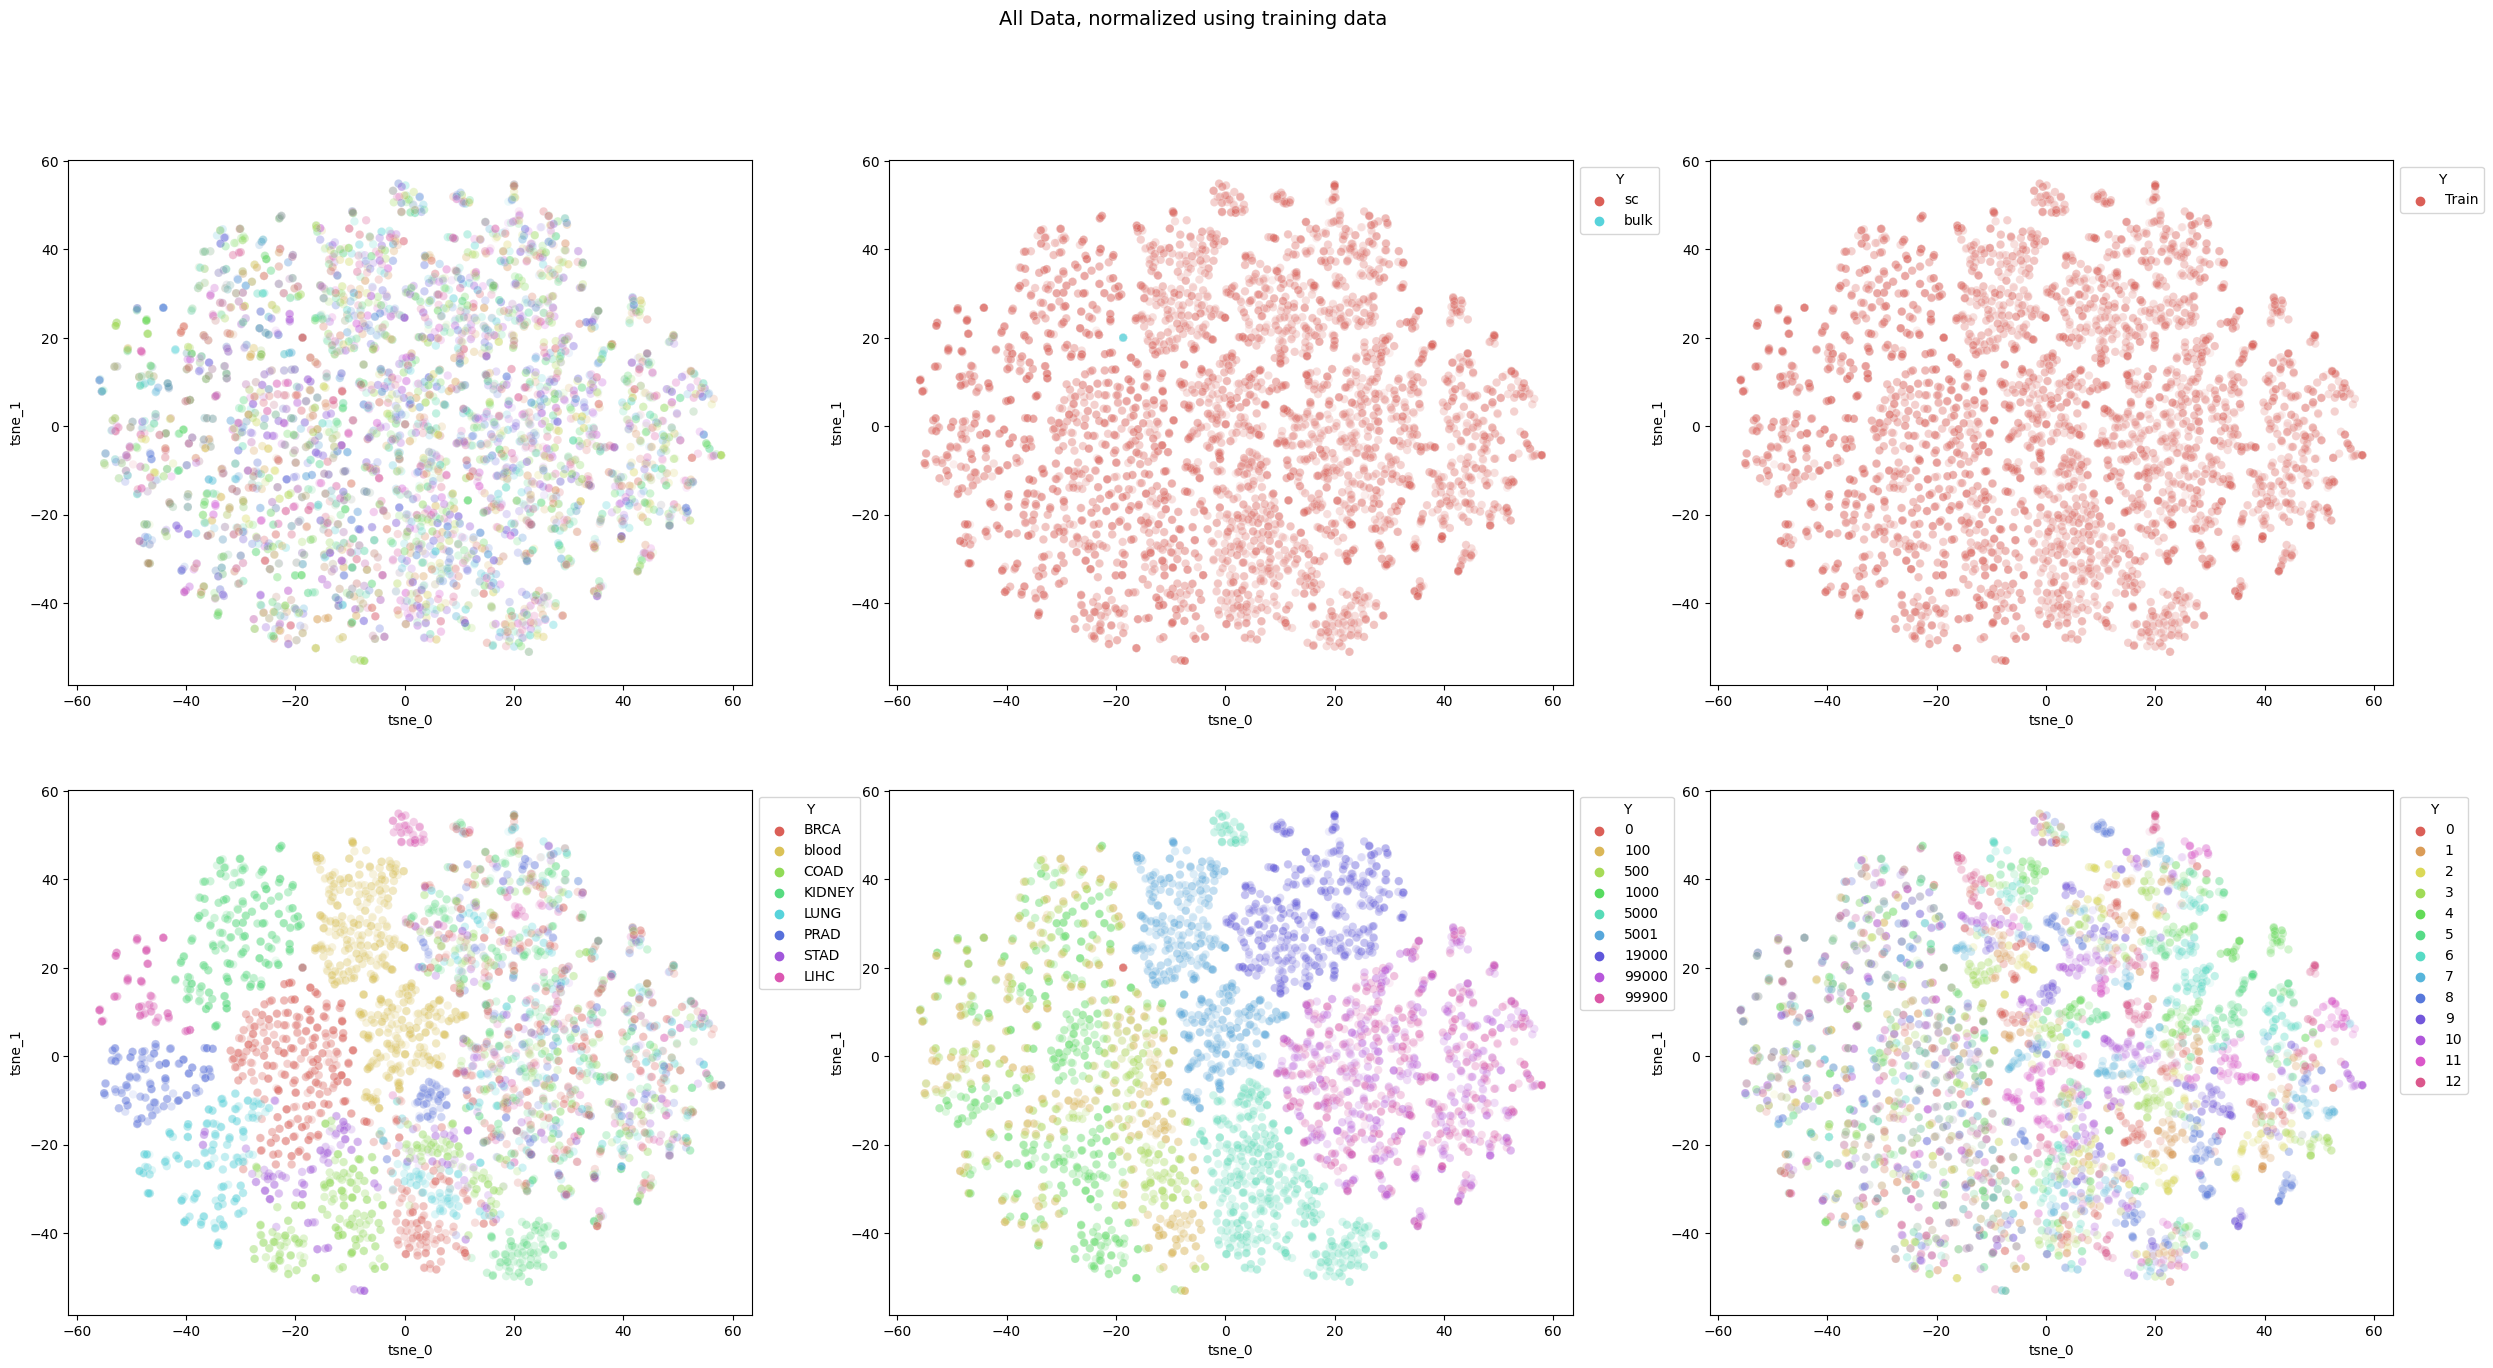

In [25]:
## plot samples
idx_tmp = np.random.choice(range(X_full.shape[0]), 10000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].samp_type.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cancer_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].num_blood.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run BuDDI**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the weighting of the loss for the latent space classifications against the reconstruction (100, 1000, 10000)
2.  the number of epochs  (50, 100, 200)

2024-06-12 11:19:46.410255: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_h2_1/bias/Assign' id:1090 op device:{requested: '', assigned: ''} def:{{{node cls_h2_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](cls_h2_1/bias, cls_h2_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-12 11:19:46.634748: W tensorflow/c/c_api.cc:304] Operation '{name:'z_samp_slack/truediv/y' id:1129 op device:{requested: '', assigned: ''} def:{{{node z_samp_slack/truediv/y}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node

test_size_samp: 500
train_size_samp: 4500


2024-06-12 11:19:47.673315: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/decoder_out_1/kernel/v/Assign' id:3235 op device:{requested: '', assigned: ''} def:{{{node training/Adam/decoder_out_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/decoder_out_1/kernel/v, training/Adam/decoder_out_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-12 11:19:48.458848: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/AddN' id:1925 op device:{requested: '', assigned: ''} def:{{{node loss_1/AddN}} = AddN[N=4, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul, loss_1/mul_1, loss_1/mul_2, loss_1/mul_3)}}' was changed by setting attribute after it was run by a session. This mutation will have n

Elapsed:  698.0946424007416
Epoch:  199
INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_known_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_known_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_unlab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_unlab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_lab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_encoder_lab/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_decoder/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_decoder/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_classifier/assets


INFO:tensorflow:Assets written to: /home/natalie/projects/checkouts/buddi_atac/buddi_atac/tcga_analysis/../results/buddiM2_tcga//all-tcga_classifier/assets


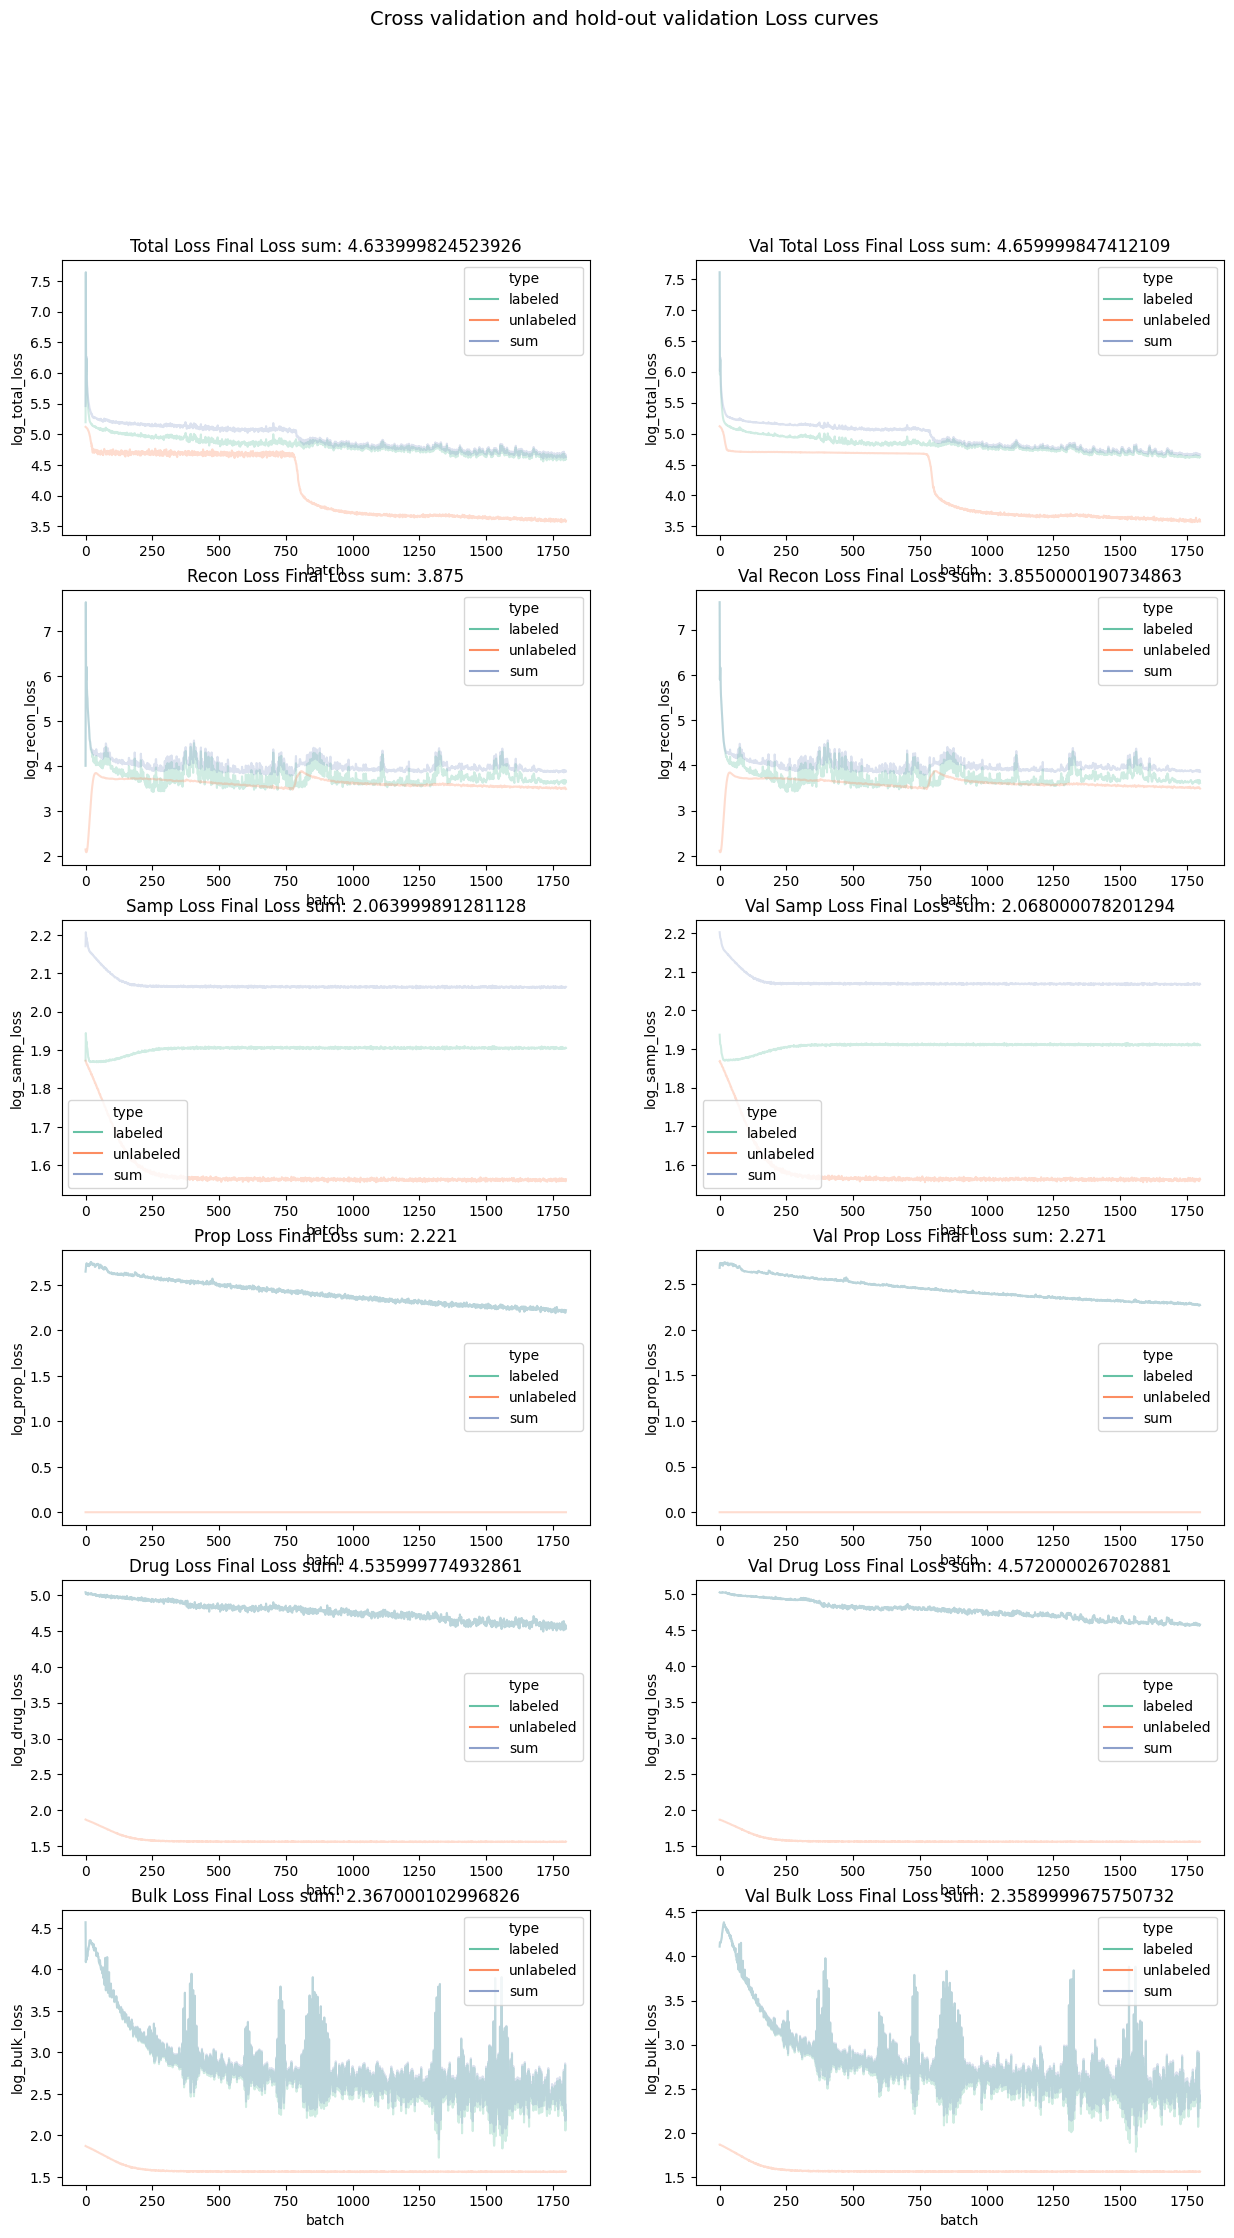

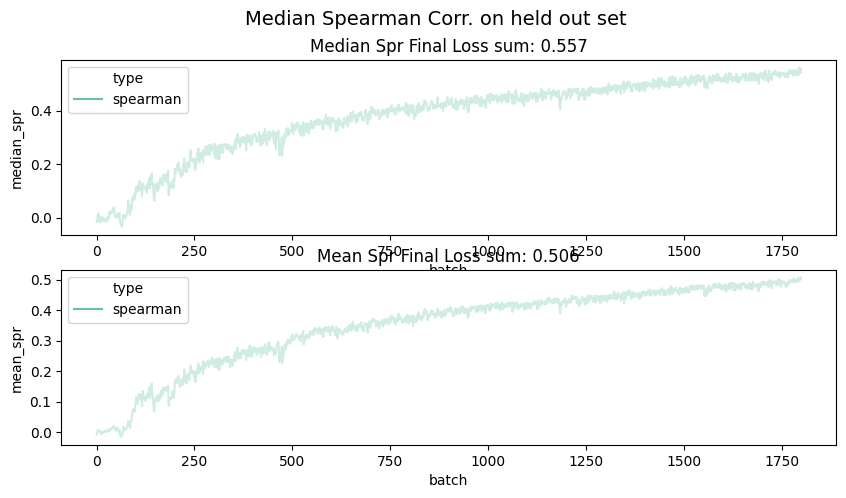

In [31]:
curr_n_epoch=200
curr_wt = 10

params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt*10, alpha_drug=curr_wt*100)


curr_res_id = f"{res_id}"
res = buddi.train_buddi(res_data_path, curr_res_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)


## visualize latent spaces

In [32]:
Y_full

CD4+ naïve T  CD4+ memory T  CD8+ naïve T        NK  CD14 mono  CD16 mono  \
0       0.211958       0.160168      0.010198  0.050390   0.008198   0.006999   
0       0.103179       0.010598      0.064987  0.033793   0.008798   0.398120   
0       0.003199       0.024395      0.676465  0.021996   0.016997   0.018796   
0       0.045591       0.200160      0.053989  0.045791   0.037193   0.016997   
0       0.007199       0.014797      0.068186  0.014397   0.001400   0.107179   
..           ...            ...           ...       ...        ...        ...   
0       0.033684       0.123421      0.002526  0.003421   0.136789   0.018842   
0       0.040000       0.090000      0.010000  0.160000   0.110000   0.040000   
0       0.072985       0.005999      0.089982  0.017397   0.007199   0.284943   
0       0.004000       0.002000      0.002000  0.002000   0.002000   0.824000   
0       0.039192       0.043591      0.097780  0.010798   0.262148   0.059188   

    intermediate mono  memory B      MAIT  CD8+ activated T   naïve B  \
0            0.004199  0.017596  0.314537          0.002999  0.188362   
0            0.000600  0.019196  0.004399          0.179564  0.141572   
0            0.002200  0.002599  0.027195          0.019596  0.131574   
0            0.004199  0.058188  0.026595          0.006199  0.002000   
0            0.106379  0.457109  0.035393          0.054589  0.097381   
..                ...       ...       ...               ...       ...   
0            0.007579  0.122368  0.118842          0.002947  0.363053   
0            0.020000  0.010000  0.100000          0.020000  0.130000   
0            0.046191  0.023395  0.127774          0.242751  0.040192   
0            0.016000  0.026000  0.038000          0.036000  0.012000   
0            0.098980  0.080384  0.030594          0.166167  0.017796   

         pDC       mDC  
0   0.014197  0.010198  
0   0.004199  0.030994  
0   0.025595  0.029394  
0   0.473705  0.029394  
0   0.002599  0.033393  
..       ...       ...  
0   0.025789  0.040737  
0   0.130000  0.140000  
0   0.018396  0.022795  
0   0.028000  0.008000  
0   0.059588  0.033793  

[4206 rows x 13 columns]

In [33]:
cancer_df

BRCA  COAD  KIDNEY  LIHC  LUNG  PRAD  STAD  blood
0        0     0       0     0     0     0     0      1
1        0     0       0     0     0     0     0      1
2        0     0       0     0     0     0     0      1
3        0     0       0     0     0     0     0      1
4        0     0       0     0     0     0     0      1
...    ...   ...     ...   ...   ...   ...   ...    ...
4201     1     0       0     0     0     0     0      0
4202     1     0       0     0     0     0     0      0
4203     1     0       0     0     0     0     0      0
4204     0     0       0     0     1     0     0      0
4205     0     0       0     0     1     0     0      0

[4206 rows x 8 columns]

In [34]:
meta_df

sample_id  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...  BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...  BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022...   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...  BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005...   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...  BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003...   
...                                                                                               ...   
BRCA_IC34 -1-0-0-0-0                                                                       BRCA_IC34    
BRCA_IC12 -1-0-0-0                                                                         BRCA_IC12    
BRCA_IC04 -1-0-0                                                                           BRCA_IC04    
LUNG_IC42 -1-0                                                                             LUNG_IC42    
LUNG_IC06 -0-1                                                                             LUNG_IC06    

                                                   cancer_type isTraining  \
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       blood      Train   
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       blood      Train   
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       blood      Train   
...                                                        ...        ...   
BRCA_IC34 -1-0-0-0-0                                      BRCA      Train   
BRCA_IC12 -1-0-0-0                                        BRCA      Train   
BRCA_IC04 -1-0-0                                          BRCA      Train   
LUNG_IC42 -1-0                                            LUNG      Train   
LUNG_IC06 -0-1                                            LUNG      Train   

                                                    num_blood samp_type  Y_max  
BRCA_01112370_4F6F_4A20_9BE0_7975C3465268_X017_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_0142AAAC_FFE8_43B7_AB99_02F7A1740567_X022_...       5001        sc  blood  
BRCA_037238B0_8FB6_4ECC_9970_93E84F9286EF_X005_...       5001        sc  blood  
BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X003_...       5001        sc  blood  
...                                                       ...       ...    ...  
BRCA_IC34 -1-0-0-0-0                                        0      bulk   BRCA  
BRCA_IC12 -1-0-0-0                                          0      bulk   BRCA  
BRCA_IC04 -1-0-0                                            0      bulk   BRCA  
LUNG_IC42 -1-0                                              0      bulk   LUNG  
LUNG_IC06 -0-1                                              0      bulk   LUNG  

[4206 rows x 6 columns]

In [35]:
# read in models

res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/{exp_id}_classifier")
res1_unk_prop_vae = res.unknown_prop_vae




2024-06-12 11:42:31.282581: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_71' id:5938 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_71}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_34, Identity_675)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-06-12 11:42:31.831619: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_97' id:6325 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_97}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_37, Identity_701)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-06-12 11:42:32.087778: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_113' id:6503 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_113}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_47, Identity_717)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-06-12 11:42:32.352785: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_121' id:6596 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_121}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_51, Identity_725)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### plot data

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-06-12 11:42:38.650216: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack/add/z_samp_slack/add' id:6043 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack/add/z_samp_slack/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack_3/BiasAdd, tf_op_layer_z_samp_slack/mul/z_samp_slack/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-06-12 11:42:38.923388: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out_2/Softmax' id:6611 op d

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


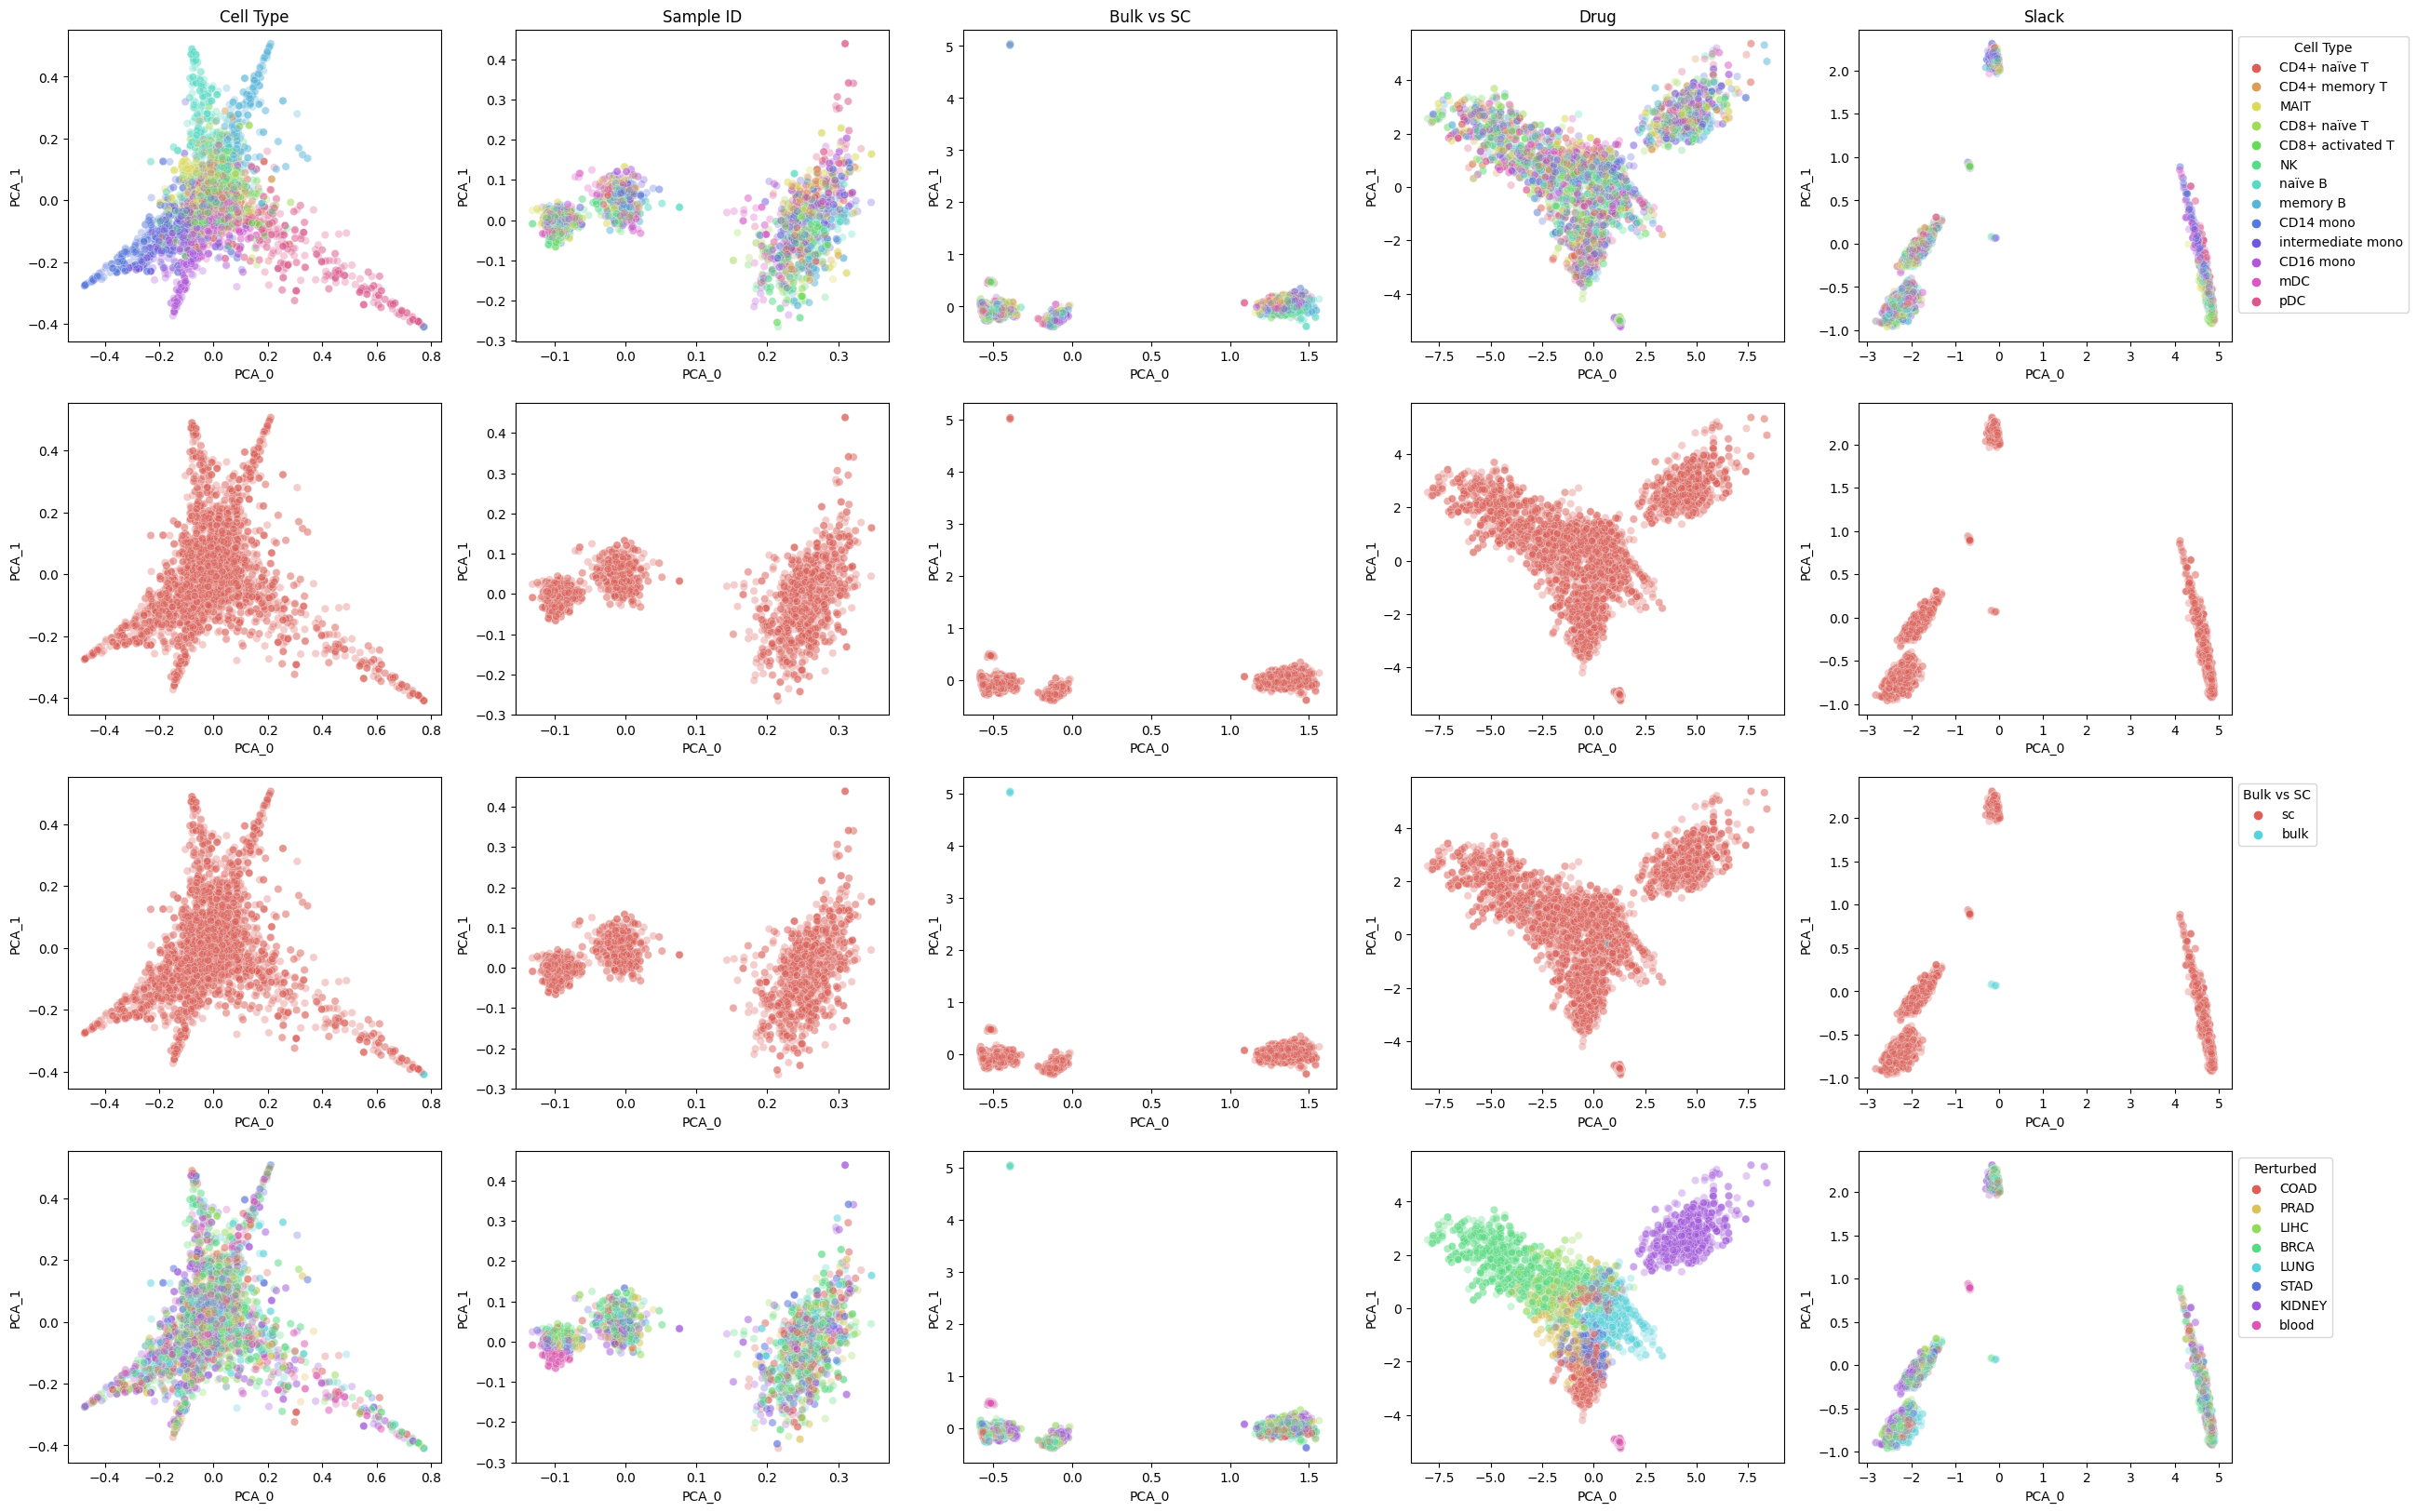

In [36]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp = np.where(np.logical_or(meta_df.cancer_type == "BRCA", meta_df.cancer_type == "LUNG"))[0]
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[[0]*5000]


drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

bulk_temp =np.copy(meta_df.samp_type)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, drug_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True, hide_sample_ids=True, alpha=0.3)

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


In [38]:
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
len(idx_tmp)

4206

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-06-12 11:43:01.824116: W tensorflow/c/c_api.cc:304] Operation '{name:'decoder_out_3/Sigmoid' id:1286 op device:{requested: '', assigned: ''} def:{{{node decoder_out_3/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder_out_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


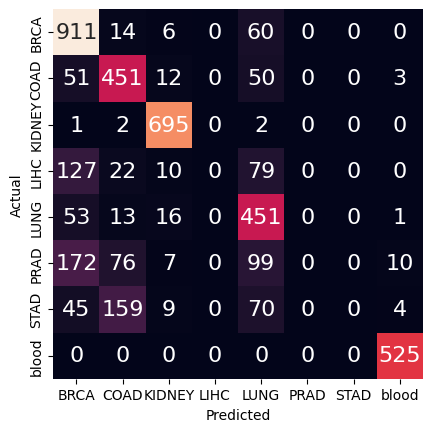

In [39]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_len = len(idx_tmp)
idx_tmp = np.append(idx_tmp, idx_tmp)[0:8000]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


_, _, ct_pred, _ = res1_unk_prop_vae.predict(X_temp, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)[0:idx_len]
ct_true = perturb_temp[0:idx_len]
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [40]:
print(classification_report(ct_true, ct_pred))

              precision    recall  f1-score   support

           0       0.67      0.92      0.77       991
           1       0.61      0.80      0.69       567
           2       0.92      0.99      0.96       700
           3       0.00      0.00      0.00       238
           4       0.56      0.84      0.67       534
           5       0.00      0.00      0.00       364
           6       0.00      0.00      0.00       287
           7       0.97      1.00      0.98       525

    accuracy                           0.72      4206
   macro avg       0.47      0.57      0.51      4206
weighted avg       0.58      0.72      0.64      4206



/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

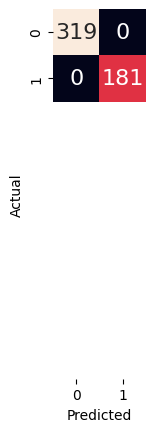

In [41]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.samp_type == "bulk")[0]
idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


_, _, ct_pred, _ = res1_unk_prop_vae.predict(X_temp, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)
ct_true = perturb_temp
labels = index_drug[[0, 1, 2]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [42]:
print(classification_report(ct_true, ct_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           4       1.00      1.00      1.00       181

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



# now classify the unseen cfDNA

In [43]:
# now test

# format into dataframe
cfdna_X = pd.DataFrame(cfdna_test.X.todense())
cfdna_X.columns = cfdna_test.var.gene_ids
cfdna_X = cfdna_X[union_genes]


# make metadata table
meta_cfdna_test = cfdna_test.obs
meta_cfdna_test = meta_cfdna_test[["sample_id", "cancer_type"]]
meta_cfdna_test["isTraining"] = "Train"
meta_cfdna_test["num_blood"] = 0
meta_cfdna_test["samp_type"] = "bulk"


# repeat 500 times for batch size
idx_tmp = np.random.choice([0,1,2], 500, replace=True)
X_cf = np.copy(cfdna_X)
X_cf = X_cf[idx_tmp,]


Y_cfdna_test = Y_test.iloc[np.random.choice(range(Y_test.shape[0]), cfdna_X.shape[0])]
Y_temp = np.copy(Y_cfdna_test)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
#Y_temp = cancer_df.columns[Y_temp]


label_cf = index_label[[0]*500]
drug_cf = meta_cfdna_test.cancer_type.iloc[idx_tmp]
bulk_cf = [99900]*500

## normalize within sample
X_cf = np.clip(X_cf, 0, clip_upper)

# now normalize with the scaler trained on the 
# training data
X_cf = scaler.transform(X_cf)




/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [44]:
ct_true = cfdna_test.obs.iloc[idx_tmp].cancer_type.astype(str)
ct_true[np.where(ct_true == "BRCA")[0]] = 0
ct_true[np.where(ct_true == "LUNG")[0]] = 4
ct_true = ct_true.tolist()

In [45]:
# now predict

_, _, ct_pred, _ = res1_unk_prop_vae.predict(X_cf, batch_size=500)

ct_pred = np.argmax(ct_pred, axis=1)


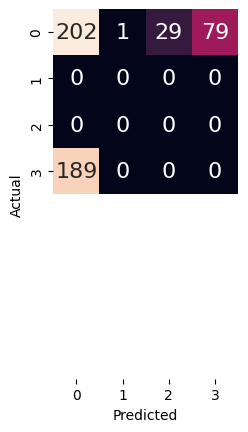

In [46]:


cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

In [47]:
print(classification_report(ct_true, ct_pred))

              precision    recall  f1-score   support

           0       0.52      0.65      0.58       311
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00       189

    accuracy                           0.40       500
   macro avg       0.13      0.16      0.14       500
weighted avg       0.32      0.40      0.36       500



/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [48]:
# make the original DF
idx_tmp = np.where(np.logical_or(meta_df.cancer_type == "BRCA", meta_df.cancer_type == "LUNG"))[0]
idx_tmp = np.where(meta_df.samp_type == "bulk")[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

drug_temp = np.copy(Drug_full)
drug_temp = drug_temp[idx_tmp]
drug_temp = index_drug[drug_temp]

# make the cfDNA DF

# format into dataframe
cfdna_X = pd.DataFrame(cfdna_test.X.todense())
cfdna_X.columns = cfdna_test.var.gene_ids
cfdna_X = cfdna_X[union_genes]


# make metadata table
meta_cfdna_test = cfdna_test.obs
meta_cfdna_test = meta_cfdna_test[["sample_id", "cancer_type"]]
meta_cfdna_test["isTraining"] = "Train"
meta_cfdna_test["num_blood"] = 0
meta_cfdna_test["samp_type"] = "bulk"


# repeat 500 times for batch size
idx_tmp = np.random.choice([0,1,2], 500, replace=True)
X_cf = np.copy(cfdna_X)
X_cf = X_cf[idx_tmp,]

## normalize within sample
X_cf = np.clip(X_cf, 0, clip_upper)

# now normalize with the scaler trained on the 
# training data
X_cf = scaler.transform(X_cf)


drug_cf = meta_cfdna_test.cancer_type.iloc[idx_tmp].tolist()


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(5500, 2)
(5500, 2)


<AxesSubplot: xlabel='PCA_0', ylabel='PCA_1'>

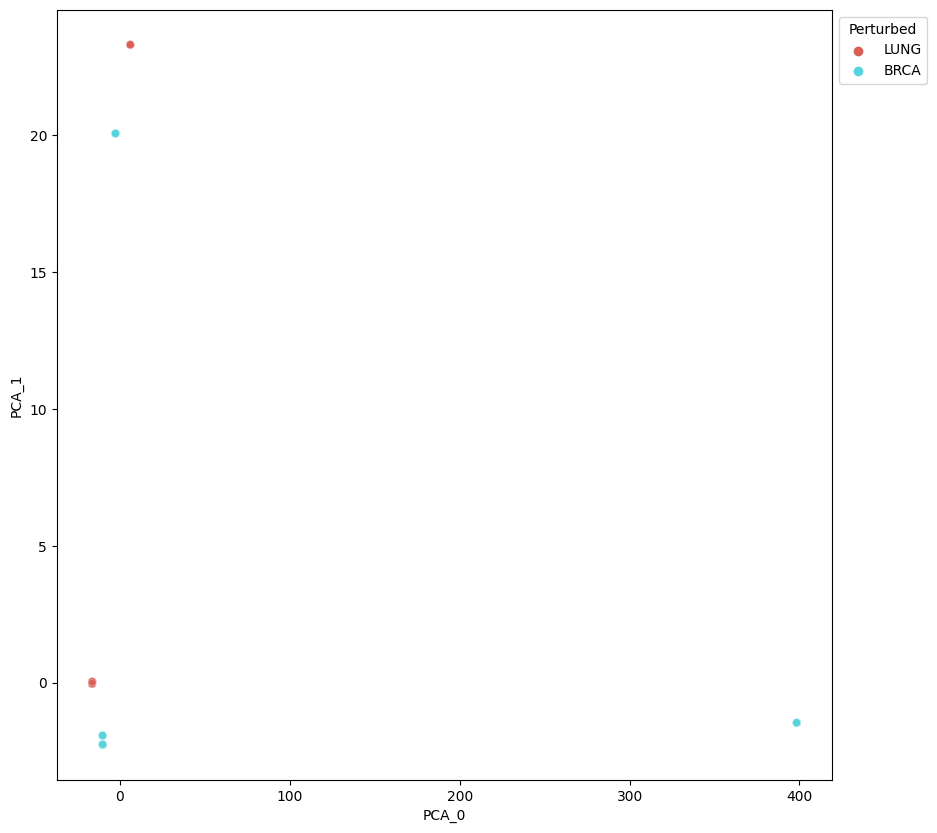

In [49]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

X_cf = np.concatenate([X_temp, X_cf], axis=0)
drug_cf = drug_temp.tolist() + drug_cf

z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _ = res1_enc_unlab.predict(X_cf, batch_size=500)

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
fig, axs = plt.subplots(figsize=(10,10))

vp.plot_pca(plot_df, color_vec=drug_cf, ax=axs, title="", alpha=0.3, legend_title="Perturbed")


# Try predicting with another model

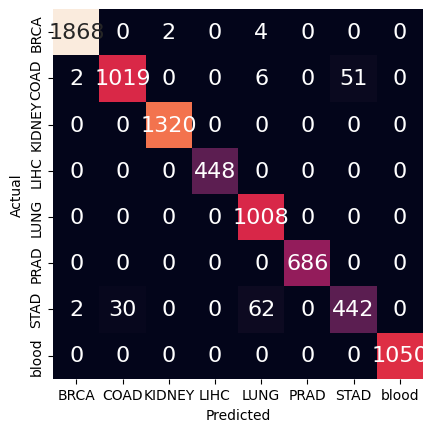

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00      1874
        COAD       0.97      0.95      0.96      1078
      KIDNEY       1.00      1.00      1.00      1320
        LIHC       1.00      1.00      1.00       448
        LUNG       0.93      1.00      0.97      1008
        PRAD       1.00      1.00      1.00       686
        STAD       0.90      0.82      0.86       536
       blood       1.00      1.00      1.00      1050

    accuracy                           0.98      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.98      0.98      0.98      8000



In [50]:
from sklearn.neural_network import MLPClassifier

idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_len = len(idx_tmp)
idx_tmp = np.append(idx_tmp, idx_tmp)[0:8000]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

training_X = X_temp
training_y = perturb_temp

# predict the cancer type (drug here) from the peaks
clf = MLPClassifier(random_state=1, max_iter=300)

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(training_X)

# plot CM
ct_pred = pred_labels
ct_true = training_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


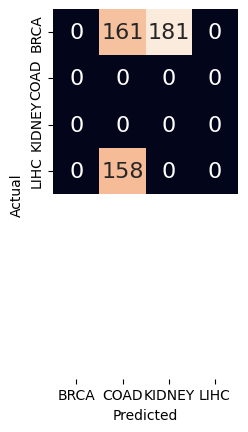

              precision    recall  f1-score   support

        BRCA       0.00      0.00      0.00     342.0
        COAD       0.00      0.00      0.00       0.0
      KIDNEY       0.00      0.00      0.00       0.0
        LIHC       0.00      0.00      0.00     158.0

    accuracy                           0.00     500.0
   macro avg       0.00      0.00      0.00     500.0
weighted avg       0.00      0.00      0.00     500.0



/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [52]:
# test

# now test

# format into dataframe
cfdna_X = pd.DataFrame(cfdna_test.X.todense())
cfdna_X.columns = cfdna_test.var.gene_ids
cfdna_X = cfdna_X[union_genes]


# make metadata table
meta_cfdna_test = cfdna_test.obs
meta_cfdna_test = meta_cfdna_test[["sample_id", "cancer_type"]]
meta_cfdna_test["isTraining"] = "Train"
meta_cfdna_test["num_blood"] = 0
meta_cfdna_test["samp_type"] = "bulk"


# repeat 500 times for batch size
idx_tmp = np.random.choice([0,1,2], 500, replace=True)
X_cf = np.copy(cfdna_X)
X_cf = X_cf[idx_tmp,]


Y_cfdna_test = Y_test.iloc[np.random.choice(range(Y_test.shape[0]), cfdna_X.shape[0])]
Y_temp = np.copy(Y_cfdna_test)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
#Y_temp = cancer_df.columns[Y_temp]


label_cf = index_label[[0]*500]
drug_cf = meta_cfdna_test.cancer_type.iloc[idx_tmp]
bulk_cf = [99900]*500

## normalize within sample
X_cf = np.clip(X_cf, 0, clip_upper)

# now normalize with the scaler trained on the 
# training data
X_cf = scaler.transform(X_cf)


ct_true = cfdna_test.obs.iloc[idx_tmp].cancer_type.astype(str)
ct_true[np.where(ct_true == "BRCA")[0]] = 0
ct_true[np.where(ct_true == "LUNG")[0]] = 4
ct_true = ct_true.tolist()



# predict
pred_labels = clf.predict(X_cf)

# plot CM
ct_pred = pred_labels
labels = index_drug[[0, 1, 2, 3]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))

In [54]:
ct_pred

array([2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2,
       2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2,
       3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2,
       3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3,
       3, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2,
       2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3,
       3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2,
       3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2,
       3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3,
       2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2,